In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import multiprocessing
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from striprtf.striprtf import rtf_to_text
from IPython.display import display
import warnings
from sklearn.exceptions import ConvergenceWarning


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore", category=ConvergenceWarning)


def hackathon_problem(json_file_path):
    # Read JSON file
    with open(json_file_path, "r") as file:
        data = file.read()
        text = rtf_to_text(data)  
        json_data = json.loads(text)

    # Load Data
    data = pd.read_csv(json_data["design_state_data"]["session_info"]["dataset"])

    # Encode categorical columns
    label_encoders = {}
    for column in data.columns:
        if data[column].dtype == 'object':
            label_encoders[column] = LabelEncoder()
            data[column] = label_encoders[column].fit_transform(data[column])

    # Define preprocessing steps based on JSON data
    preprocessing_steps = []
    for feature, details in json_data["design_state_data"]["feature_handling"].items():
        if "missing_values" in details and details["missing_values"] == "Impute":
            if details["impute_with"] == "Average of values":
                strategy = 'mean'
            else:
                strategy = 'median'
            preprocessing_steps.append((feature + '_imputer', SimpleImputer(strategy=strategy)))

    # Apply preprocessing steps
    for step in preprocessing_steps:
        feature_name, transformer = step
        data[feature_name] = transformer.fit_transform(data[[feature_name]])

    # Separate X and y
    selected_features = [feature for feature, details in json_data["design_state_data"]["feature_handling"].items() if details["is_selected"]]
    X = data[selected_features]
    Y = data[json_data["design_state_data"]["target"]["target"]]


    # Split Data
    train_ratio = json_data["design_state_data"]["train"]["train_ratio"]
    random_seed = json_data["design_state_data"]["train"]["random_seed"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 - train_ratio, random_state=random_seed)

    
    
    # Get the number of available CPU cores for parallelism
    num_cores = multiprocessing.cpu_count()
    
    selected_algorithm = None
    for algorithm, details in json_data["design_state_data"]["algorithms"].items():
        if details["is_selected"]:
            selected_algorithm = algorithm
            break
    
    if selected_algorithm == "RandomForestClassifier":
        model = RandomForestClassifier()
        parameters = {
            "n_estimators": np.linspace(details["min_trees"], details["max_trees"], num=3, dtype=int),
            "max_depth": np.linspace(details["min_depth"], details["max_depth"], num=3, dtype=int),
            "min_samples_leaf": np.linspace(details["min_samples_per_leaf_min_value"], details["min_samples_per_leaf_max_value"], num=3, dtype=int)
        }
        # Modify GridSearchCV instantiation to use parallel processing
        grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=num_cores)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_


    # Evaluate Models
        Y_pred = best_model.predict(X_test)


        confusion_mat = confusion_matrix(Y_test, Y_pred)

        # Create heatmap with seaborn
        sns.heatmap(confusion_mat, annot=True, cmap="viridis", fmt="d", cbar=False,
                    linewidths=0.5, linecolor='gray', square=True,
                    xticklabels=True, yticklabels=True, annot_kws={"size": 10})
        
        # Customize axis labels
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        # Show plot
        plt.show()      
        # Assign value to classification_rep_df
        classification_rep_dict = classification_report(Y_test, Y_pred, output_dict=True)
        classification_rep_df = pd.DataFrame(classification_rep_dict)
        # Add some styling to the DataFrame
        classification_rep_styled = classification_rep_df.style.background_gradient(cmap='viridis')
        # Inside each block where you print the classification report, replace the print statement with the following:
        # Print the styled classification report
        print("Classification Report:")
        display(classification_rep_styled)

    
            
    if selected_algorithm == "RandomForestRegressor":
        # Your RandomForestRegressor code
        model = RandomForestRegressor()
        parameters = {
            "n_estimators": list(range(details["min_trees"], details["max_trees"] + 1)),
            "max_depth": list(range(details["min_depth"], details["max_depth"] + 1)),
            "min_samples_leaf": list(range(details["min_samples_per_leaf_min_value"], details["min_samples_per_leaf_max_value"] + 1))}
        # Modify GridSearchCV instantiation to use parallel processing
        grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=num_cores)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
    
        # Predict on test data
        Y_pred = best_model.predict(X_test)
        
        # Calculate R-squared
        r_squared = best_model.score(X_test, Y_test)
        
        # Calculate adjusted R-squared
        n = len(Y_test)
        k = X_test.shape[1]  # Number of predictors
        adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
        
        # Create DataFrame for metrics
        
        metrics_df = pd.DataFrame({
            'Metric': ['R-squared', 'Adjusted R-squared', 'Root Mean Squared Error (RMSE)'],
            'Value': [r_squared, adjusted_r_squared, rmse]
        })
    
        # Style DataFrame
        styled_metrics_df = (
            metrics_df.style
                .set_properties(**{'text-align': 'left'})  # Align text to the left
                .highlight_max(color='lightgreen')         # Highlight maximum value
                .set_caption('Model Evaluation Metrics')   # Add caption
        )
    
        # Display styled DataFrame
        display(styled_metrics_df)

        
    if selected_algorithm == "LinearRegression":
        # Your LinearRegression code
        best_model = LinearRegression()
        best_model.fit(X_train, Y_train)
    
        # Predict on test data
        Y_pred = best_model.predict(X_test)
        
        # Calculate R-squared
        r_squared = best_model.score(X_test, Y_test)
        
        # Calculate adjusted R-squared
        n = len(Y_test)
        k = X_test.shape[1]  # Number of predictors
        adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

        # Create DataFrame for metrics
        metrics_df = pd.DataFrame({
            'Metric': ['R-squared', 'Adjusted R-squared', 'Root Mean Squared Error (RMSE)'],
            'Value': [r_squared, adjusted_r_squared, rmse]
        })
    
        # Style DataFrame
        styled_metrics_df = (
            metrics_df.style
                .set_properties(**{'text-align': 'left'})  # Align text to the left
                .highlight_max(color='lightgreen')         # Highlight maximum value
                .set_caption('Model Evaluation Metrics')   # Add caption
        )
    
        # Display styled DataFrame
        display(styled_metrics_df)

    if selected_algorithm == "LogisticRegression":
        model = LogisticRegression()
        parameters = {
            "C": np.linspace(details["min_regparam"], details["max_regparam"], num=5),
            "max_iter": np.linspace(details["min_iter"], details["max_iter"], num=5, dtype=int),
            "l1_ratio": np.linspace(details["min_elasticnet"], details["max_elasticnet"], num=5)
        }
        
        # Modify GridSearchCV instantiation to use parallel processing
        grid_search = GridSearchCV(model, parameters, cv=5, n_jobs=num_cores)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
    
        # Evaluate Models
        Y_pred = best_model.predict(X_test)


        
        confusion_mat = confusion_matrix(Y_test, Y_pred)

        # Create heatmap with seaborn
        sns.heatmap(confusion_mat, annot=True, cmap="viridis", fmt="d", cbar=False,
                    linewidths=0.5, linecolor='gray', square=True,
                    xticklabels=True, yticklabels=True, annot_kws={"size": 10})
        
        # Customize axis labels
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        # Show plot
        plt.show()      
        # Assign value to classification_rep_df
        classification_rep_dict = classification_report(Y_test, Y_pred, output_dict=True)
        classification_rep_df = pd.DataFrame(classification_rep_dict)
        # Add some styling to the DataFrame
        classification_rep_styled = classification_rep_df.style.background_gradient(cmap='viridis')
        # Inside each block where you print the classification report, replace the print statement with the following:
        # Print the styled classification report
        print("Classification Report:")
        display(classification_rep_styled)

    
        
    if selected_algorithm in ["RidgeRegression", "LassoRegression"]:
        if selected_algorithm == "RidgeRegression":
            model = Ridge()
        elif selected_algorithm == "LassoRegression":
            model = Lasso()
    
        parameters = {
            "alpha": [i/10 for i in range(int(details["min_regparam"]*10), int(details["max_regparam"]*10)+1)],
            "max_iter": list(range(details["min_iter"], details["max_iter"] + 1))}
        # Modify GridSearchCV instantiation to use parallel processing
        grid_search = GridSearchCV(model, parameters, cv=5)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
    
        # Evaluate Models
        Y_pred = best_model.predict(X_test)
        
        # Calculate R-squared
        r_squared = best_model.score(X_test, Y_test)
        
        # Calculate adjusted R-squared
        n = len(Y_test)
        k = X_test.shape[1]  # Number of predictors
        adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

        # Create DataFrame for metrics
        metrics_df = pd.DataFrame({
            'Metric': ['R-squared', 'Adjusted R-squared', 'Root Mean Squared Error (RMSE)'],
            'Value': [r_squared, adjusted_r_squared, rmse]
        })
    
        # Style DataFrame
        styled_metrics_df = (
            metrics_df.style
                .set_properties(**{'text-align': 'left'})  # Align text to the left
                .highlight_max(color='lightgreen')         # Highlight maximum value
                .set_caption('Model Evaluation Metrics')   # Add caption
        )
    
        # Display styled DataFrame
        display(styled_metrics_df)

        
    if selected_algorithm == "ElasticNetRegression":
        model = ElasticNet()
        # Hyperparameters
        parameters = {
            "alpha": [i/10 for i in range(int(details["min_regparam"]*10), int(details["max_regparam"]*10)+1)],
            "l1_ratio": [i/10 for i in range(int(details["min_elasticnet"]*10), int(details["max_elasticnet"]*10)+1)],
            "max_iter": list(range(details["min_iter"], details["max_iter"] + 1))}
        # Modify GridSearchCV instantiation to use parallel processing
        grid_search = GridSearchCV(model, parameters, cv=5)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
    
        # Evaluate Models
        Y_pred = best_model.predict(X_test)
        
        # Calculate R-squared
        r_squared = best_model.score(X_test, Y_test)
        
        # Calculate adjusted R-squared
        n = len(Y_test)
        k = X_test.shape[1]  # Number of predictors
        adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

        # Create DataFrame for metrics
        metrics_df = pd.DataFrame({
            'Metric': ['R-squared', 'Adjusted R-squared', 'Root Mean Squared Error (RMSE)'],
            'Value': [r_squared, adjusted_r_squared, rmse]
        })
    
        # Style DataFrame
        styled_metrics_df = (
            metrics_df.style
                .set_properties(**{'text-align': 'left'})  # Align text to the left
                .highlight_max(color='lightgreen')         # Highlight maximum value
                .set_caption('Model Evaluation Metrics')   # Add caption
        )
    
        # Display styled DataFrame
        display(styled_metrics_df)

        
    if selected_algorithm == "xg_boost":
        # XGBoost specific handling
        model = xgb.XGBClassifier(objective='multi:softmax', 
                                   booster='dart' if details['dart'] else 'gbtree',
                                   tree_method = details['tree_method'] if details['tree_method'] != "" else "auto",
                                   random_state=details['random_state'],)
        parameters = {
            'n_estimators': [details["max_num_of_trees"]] if details["max_num_of_trees"] > 0 else [5],
            'max_depth': details['max_depth_of_tree'],
            'learning_rate': [value * 0.001 for value in details['learningRate']],
            'reg_alpha':  [value * 0.01 for value in details['l1_regularization']],
            'reg_lambda':  [value * 0.01 for value in details['l2_regularization']],
            'gamma': [value * 0.01 for value in details['gamma']],
            'min_child_weight': [value * 0.01 for value in details['min_child_weight']],
            'subsample': [value * 0.01 for value in details['sub_sample']],
            'colsample_bytree': [value * 0.01 for value in details['col_sample_by_tree']]
        }
       
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(model, parameters, cv=5 , n_jobs=num_cores)
        
        # Fit the model with early stopping on the validation set
        grid_search.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], early_stopping_rounds=details['early_stopping_rounds'] if details['early_stopping'] else None)
        
        # Get the best model from grid search
        best_model = grid_search.best_estimator_
        
        # Make predictions on the test set
        Y_pred = best_model.predict(X_test)
        


        confusion_mat = confusion_matrix(Y_test, Y_pred)

        # Create heatmap with seaborn
        sns.heatmap(confusion_mat, annot=True, cmap="viridis", fmt="d", cbar=False,
                    linewidths=0.5, linecolor='gray', square=True,
                    xticklabels=True, yticklabels=True, annot_kws={"size": 10})
        
        # Customize axis labels
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        # Show plot
        plt.show()      
        # Assign value to classification_rep_df
        classification_rep_dict = classification_report(Y_test, Y_pred, output_dict=True)
        classification_rep_df = pd.DataFrame(classification_rep_dict)
        # Add some styling to the DataFrame
        classification_rep_styled = classification_rep_df.style.background_gradient(cmap='viridis')
        # Inside each block where you print the classification report, replace the print statement with the following:
        # Print the styled classification report
        print("Classification Report:")
        display(classification_rep_styled)

    
    if selected_algorithm == "DecisionTreeClassifier":
        # Decision Tree Classifier specific handling
        criterion = 'gini' if details['use_gini'] else 'entropy'
        # Fix the following line to use 'use_entropy' instead of 'use_best'
        splitter = 'best' if details['use_best'] and not details['use_random'] else 'random'
        
        model = DecisionTreeClassifier(criterion=criterion, splitter=splitter)
        parameters = {
            'max_depth': list(range(details['min_depth'], details['max_depth'] + 1)),
            'min_samples_leaf': details['min_samples_per_leaf']}
        grid_search = GridSearchCV(model, parameters, cv=5)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
        Y_pred = best_model.predict(X_test)


        confusion_mat = confusion_matrix(Y_test, Y_pred)

        # Create heatmap with seaborn
        sns.heatmap(confusion_mat, annot=True, cmap="viridis", fmt="d", cbar=False,
                    linewidths=0.5, linecolor='gray', square=True,
                    xticklabels=True, yticklabels=True, annot_kws={"size": 10})
        
        # Customize axis labels
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        # Show plot
        plt.show()      
        # Assign value to classification_rep_df
        classification_rep_dict = classification_report(Y_test, Y_pred, output_dict=True)
        classification_rep_df = pd.DataFrame(classification_rep_dict)
        # Add some styling to the DataFrame
        classification_rep_styled = classification_rep_df.style.background_gradient(cmap='viridis')
        # Inside each block where you print the classification report, replace the print statement with the following:
        # Print the styled classification report
        print("Classification Report:")
        display(classification_rep_styled)

      
    if selected_algorithm == "DecisionTreeRegressor":
        # Decision Tree Regressor specific handling
        splitter = 'best' if details.get('use_best', False) and not details.get('use_random', False) else 'random'
        random_state = details.get('random_state', 10)  # Use the provided random state or default to 10
        
        model = DecisionTreeRegressor( splitter=splitter, random_state=random_state)
        parameters = {
            'max_depth': list(range(details['min_depth'], details['max_depth'] + 1)),
            'min_samples_leaf': details['min_samples_per_leaf']
        }
        
        grid_search = GridSearchCV(model, parameters, cv=5)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
        
        # Predict on test data
        Y_pred = best_model.predict(X_test)
        
        # Calculate R-squared
        r_squared = best_model.score(X_test, Y_test)
        
        # Calculate adjusted R-squared
        n = len(Y_test)
        k = X_test.shape[1]  # Number of predictors
        adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

        # Create DataFrame for metrics
        metrics_df = pd.DataFrame({
            'Metric': ['R-squared', 'Adjusted R-squared', 'Root Mean Squared Error (RMSE)'],
            'Value': [r_squared, adjusted_r_squared, rmse]
        })
    
        # Style DataFrame
        styled_metrics_df = (
            metrics_df.style
                .set_properties(**{'text-align': 'left'})  # Align text to the left
                .highlight_max(color='lightgreen')         # Highlight maximum value
                .set_caption('Model Evaluation Metrics')   # Add caption
        )
    
        # Display styled DataFrame
        display(styled_metrics_df)

        
    if selected_algorithm == "SVM":
        # SVM specific handling
        kernels = []
        if details['linear_kernel']:
            kernels.append('linear')
        if details['rep_kernel']:
            kernels.append('rbf')
        if details['polynomial_kernel']:
            kernels.append('poly')
        if details['sigmoid_kernel']:
            kernels.append('sigmoid')
        
        model = SVC()
        parameters = {
            'C': details['c_value'],
            'kernel': kernels,
            'gamma': ['auto', 'scale'] if details['scale'] else details['custom_gamma_values'],
            'tol': [10 ** -details['tolerance']],
            'max_iter': [details['max_iterations']]
        }
        grid_search = GridSearchCV(model, parameters, cv=5)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
        
        # Predict on test data
        Y_pred = best_model.predict(X_test)
        


        confusion_mat = confusion_matrix(Y_test, Y_pred)

        # Create heatmap with seaborn
        sns.heatmap(confusion_mat, annot=True, cmap="viridis", fmt="d", cbar=False,
                    linewidths=0.5, linecolor='gray', square=True,
                    xticklabels=True, yticklabels=True, annot_kws={"size": 10})
        
        # Customize axis labels
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        # Show plot
        plt.show()      
        # Assign value to classification_rep_df
        classification_rep_dict = classification_report(Y_test, Y_pred, output_dict=True)
        classification_rep_df = pd.DataFrame(classification_rep_dict)
        # Add some styling to the DataFrame
        classification_rep_styled = classification_rep_df.style.background_gradient(cmap='viridis')
        # Inside each block where you print the classification report, replace the print statement with the following:
        # Print the styled classification report
        print("Classification Report:")
        display(classification_rep_styled)

    
    
    if selected_algorithm == "KNN":
        model = KNeighborsClassifier()
        parameters = {
            'n_neighbors': details['k_value'],
            'weights': ['uniform', 'distance'] if details['distance_weighting'] else ['uniform'],
            'algorithm': ['auto'] if details['neighbour_finding_algorithm'] == "Automatic" else [details['neighbour_finding_algorithm']],
            'p': [details['p_value']] if details['p_value'] > 0 else [1]
        }
        grid_search = GridSearchCV(model, parameters, cv=5)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
        Y_pred = best_model.predict(X_test)

        confusion_mat = confusion_matrix(Y_test, Y_pred)

        # Create heatmap with seaborn
        sns.heatmap(confusion_mat, annot=True, cmap="viridis", fmt="d", cbar=False,
                    linewidths=0.5, linecolor='gray', square=True,
                    xticklabels=True, yticklabels=True, annot_kws={"size": 10})
        
        # Customize axis labels
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        # Show plot
        plt.show()      
        # Assign value to classification_rep_df
        classification_rep_dict = classification_report(Y_test, Y_pred, output_dict=True)
        classification_rep_df = pd.DataFrame(classification_rep_dict)
        # Add some styling to the DataFrame
        classification_rep_styled = classification_rep_df.style.background_gradient(cmap='viridis')
        # Inside each block where you print the classification report, replace the print statement with the following:
        # Print the styled classification report
        print("Classification Report:")
        display(classification_rep_styled)

    
    if selected_algorithm == "neural_network":
        # Neural Network specific handling
  # Initialize the MLPClassifier model with early stopping parameter
        model = MLPClassifier(early_stopping=details['early_stopping'])

        # Define the parameters for grid search
        parameters = {
            'hidden_layer_sizes': details['hidden_layer_sizes'],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'alpha': [details['alpha_value']] if details['alpha_value'] > 0 else [.1],
            'max_iter': [details['max_iterations']] if details['max_iterations'] > 0 else [100],
            'tol': [10 ** -details['convergence_tolerance']] if details['convergence_tolerance'] > 0 else [0.1],
            'solver': [details['solver'].lower()],
            'learning_rate_init': [details['initial_learning_rate']] if details['initial_learning_rate'] > 0 else [0.01],
            'shuffle': [details['shuffle_data']],
            'batch_size': ['auto'] if details['automatic_batching'] else [details['batch_size']],
            'beta_1': [details['beta_1']] if details['beta_1'] != 0 else [.1],
            'beta_2': [details['beta_2']] if details['beta_2'] != 0 else [.1],
            'epsilon': [details['epsilon']] if details['epsilon'] != 0 else [.1],
            'power_t': [details['power_t']] if details['power_t'] != 0 else [.1],
            'momentum': [details['momentum']] if details['momentum'] != 0 else [.1],
            'nesterovs_momentum': [details['use_nesterov_momentum']]
        }
        grid_search = GridSearchCV(model, parameters, cv=5)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
        Y_pred = best_model.predict(X_test)

        confusion_mat = confusion_matrix(Y_test, Y_pred)

        # Create heatmap with seaborn
        sns.heatmap(confusion_mat, annot=True, cmap="viridis", fmt="d", cbar=False,
                    linewidths=0.5, linecolor='gray', square=True,
                    xticklabels=True, yticklabels=True, annot_kws={"size": 10})
        
        # Customize axis labels
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        # Show plot
        plt.show()      
        # Assign value to classification_rep_df
        classification_rep_dict = classification_report(Y_test, Y_pred, output_dict=True)
        classification_rep_df = pd.DataFrame(classification_rep_dict)
        # Add some styling to the DataFrame
        classification_rep_styled = classification_rep_df.style.background_gradient(cmap='viridis')
        # Inside each block where you print the classification report, replace the print statement with the following:
        # Print the styled classification report
        print("Classification Report:")
        display(classification_rep_styled)

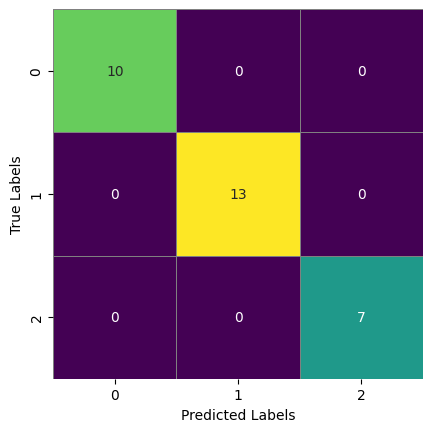

Classification Report:


,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
recall,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
f1-score,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
support,10.000000,13.000000,7.000000,1.000000,30.000000,30.000000


In [2]:
hackathon_problem("DT_Classifier.rtf")

In [3]:
hackathon_problem("DT_Regressor.rtf")

,Metric,Value
0,R-squared,1.000000
1,Adjusted R-squared,1.000000
2,Root Mean Squared Error (RMSE),0.000000


In [4]:
hackathon_problem("ElasticNetRegression.rtf")

<IPython.core.display.Javascript object>

,Metric,Value
0,R-squared,0.842478
1,Adjusted R-squared,0.817275
2,Root Mean Squared Error (RMSE),0.296120


C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Use

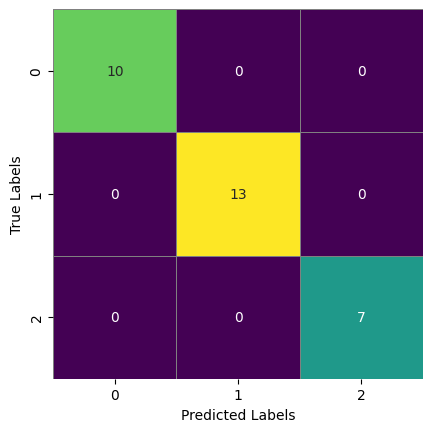

Classification Report:


,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
recall,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
f1-score,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
support,10.000000,13.000000,7.000000,1.000000,30.000000,30.000000


In [5]:
hackathon_problem("KNN.rtf")

In [6]:
hackathon_problem("LassoRegression.rtf")

<IPython.core.display.Javascript object>

,Metric,Value
0,R-squared,0.784338
1,Adjusted R-squared,0.749832
2,Root Mean Squared Error (RMSE),0.346485


In [7]:
hackathon_problem("Linear.rtf")

,Metric,Value
0,R-squared,1.000000
1,Adjusted R-squared,1.000000
2,Root Mean Squared Error (RMSE),0.000000


<IPython.core.display.Javascript object>

C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


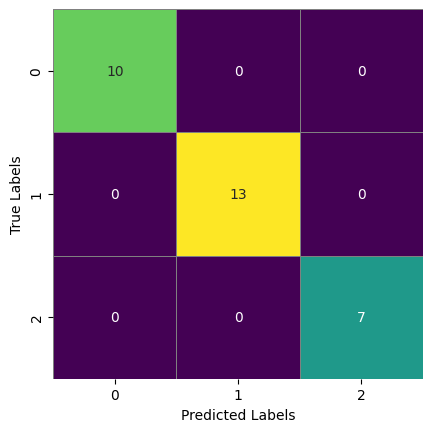

Classification Report:


,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
recall,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
f1-score,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
support,10.000000,13.000000,7.000000,1.000000,30.000000,30.000000


In [8]:
hackathon_problem("LogisticRegression.rtf")

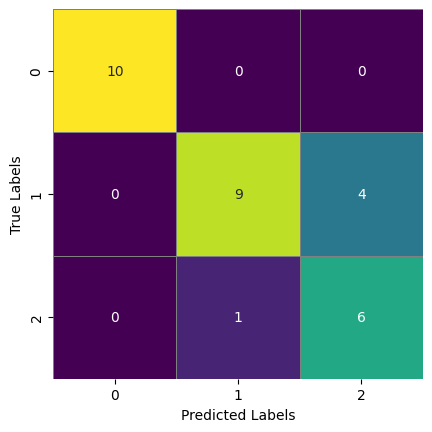

Classification Report:


,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,0.900000,0.600000,0.833333,0.833333,0.863333
recall,1.000000,0.692308,0.857143,0.833333,0.849817,0.833333
f1-score,1.000000,0.782609,0.705882,0.833333,0.829497,0.837170
support,10.000000,13.000000,7.000000,0.833333,30.000000,30.000000


In [9]:
hackathon_problem("Neural_Network.rtf")

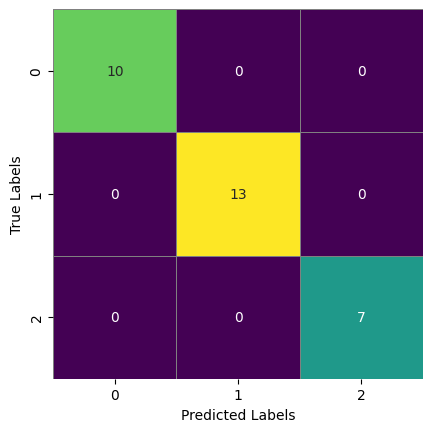

Classification Report:


,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
recall,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
f1-score,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
support,10.000000,13.000000,7.000000,1.000000,30.000000,30.000000


In [10]:
hackathon_problem("RF_Classifier.rtf")

In [11]:
hackathon_problem("RF_Regressor.rtf")

,Metric,Value
0,R-squared,1.000000
1,Adjusted R-squared,1.000000
2,Root Mean Squared Error (RMSE),0.000000


In [12]:
hackathon_problem("RidgeRegression.rtf")

<IPython.core.display.Javascript object>

,Metric,Value
0,R-squared,0.999387
1,Adjusted R-squared,0.999289
2,Root Mean Squared Error (RMSE),0.018470


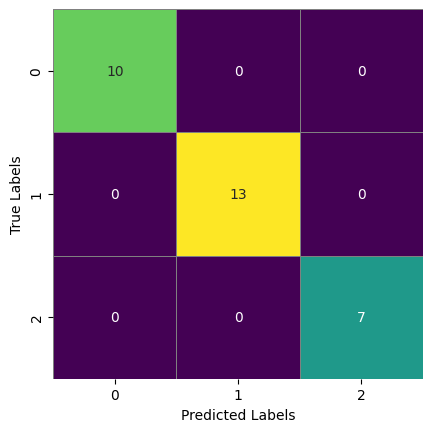

Classification Report:


,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
recall,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
f1-score,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
support,10.000000,13.000000,7.000000,1.000000,30.000000,30.000000


In [13]:
hackathon_problem("SVM.rtf")

[0]	validation_0-mlogloss:0.99140
[1]	validation_0-mlogloss:0.93887
[2]	validation_0-mlogloss:0.84715
[3]	validation_0-mlogloss:0.76654
[4]	validation_0-mlogloss:0.70373


C:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


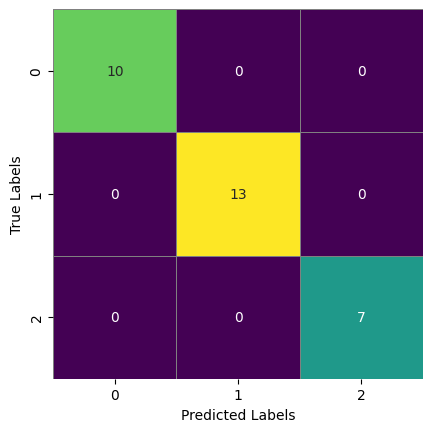

Classification Report:


,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
recall,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
f1-score,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
support,10.000000,13.000000,7.000000,1.000000,30.000000,30.000000


In [14]:
hackathon_problem("XG_Boost.rtf")